# E-commerce Churn Prediction
This report outlines the results from the churn prediction project, featuring a baseline logistic regression model and an improved model using XGBoost combined with SMOTE and RandomUnderSampler. The main goal was to predict customer churn accurately and enhance model performance using different techniques.


# Data Loading and Pre-Processing

---



In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, f1_score, recall_score, ConfusionMatrixDisplay

from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbalancedPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import shap
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Load dataset
df = pd.read_csv('OnlineRetail.csv')
# first few rows and info
print("First few rows of the dataset:")
print(df.head())

print("\nDataset info:")
print(df.info())

df.isnull().sum()  # looking for any missing values

First few rows of the dataset:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

    InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/10 8:26       2.55     17850.0  United Kingdom  
1  12/1/10 8:26       3.39     17850.0  United Kingdom  
2  12/1/10 8:26       2.75     17850.0  United Kingdom  
3  12/1/10 8:26       3.39     17850.0  United Kingdom  
4  12/1/10 8:26       3.39     17850.0  United Kingdom  

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

# Data Cleaning

In [ ]:
# Converting InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='mixed')

# Sorting by CustomerID and InvoiceDate
df.sort_values(['CustomerID', 'InvoiceDate'], inplace=True)

# Droping rows with missing CustomerID
df.dropna(subset=["CustomerID"], inplace=True)

# Filling missing values in Description column
df["Description"].fillna("Unknown", inplace=True)

# Converting CustomerID to integer type
df["CustomerID"] = df["CustomerID"].astype(int)

# Calculating TotalPurchase
df.loc[:, 'TotalPurchase'] = df['Quantity'] * df['UnitPrice']

# Handling outliers using IQR
def remove_outliers_iqr(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[column_name] >= (Q1 - 1.5 * IQR)) & (df[column_name] <= (Q3 + 1.5 * IQR))]

# Removing outliers for Quantity and UnitPrice
df = remove_outliers_iqr(df, 'Quantity')
df = remove_outliers_iqr(df, 'UnitPrice')

# Print cleaned data statistics
print("Data Summary after cleaning:")
print(df.describe())
print(df.info())

Data Summary after cleaning:
            Quantity                    InvoiceDate      UnitPrice  \
count  344393.000000                         344393  344393.000000   
mean        7.279797  2011-07-12 11:59:01.481911552       2.201251   
min       -13.000000            2010-12-01 08:26:00       0.000000   
25%         2.000000            2011-04-08 08:20:00       1.250000   
50%         5.000000            2011-08-03 11:58:00       1.650000   
75%        12.000000            2011-10-23 12:28:00       2.950000   
max        27.000000            2011-12-09 12:50:00       7.500000   
std         6.880816                            NaN       1.548459   

          CustomerID  TotalPurchase  
count  344393.000000  344393.000000  
mean    15319.637144      12.398313  
min     12347.000000     -81.000000  
25%     13988.000000       3.750000  
50%     15235.000000       9.960000  
75%     16814.000000      17.220000  
max     18287.000000     178.800000  
std      1711.461068      13.390289 

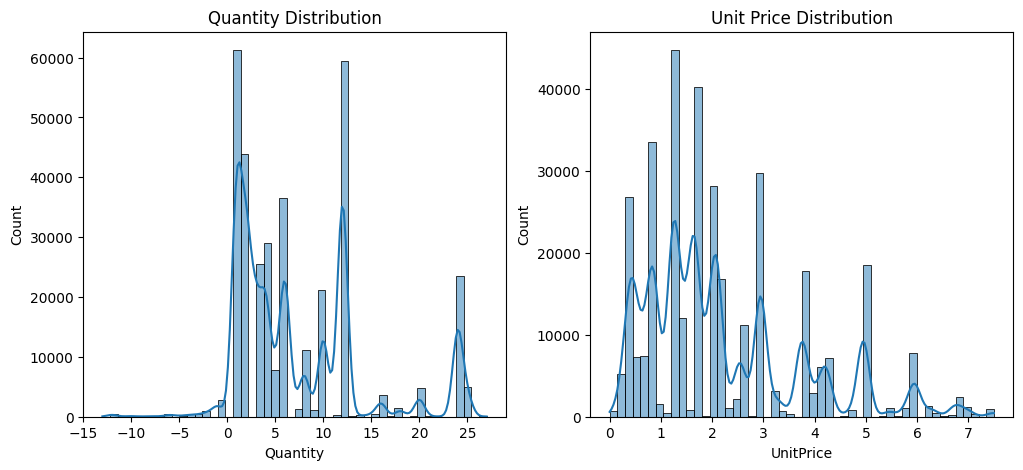

In [ ]:
#EDA before feature engineering
# Plot distribution of Quantity and UnitPrice
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['Quantity'], bins=50, kde=True)
plt.title('Quantity Distribution')

plt.subplot(1, 2, 2)
sns.histplot(df['UnitPrice'], bins=50, kde=True)
plt.title('Unit Price Distribution')
plt.show()



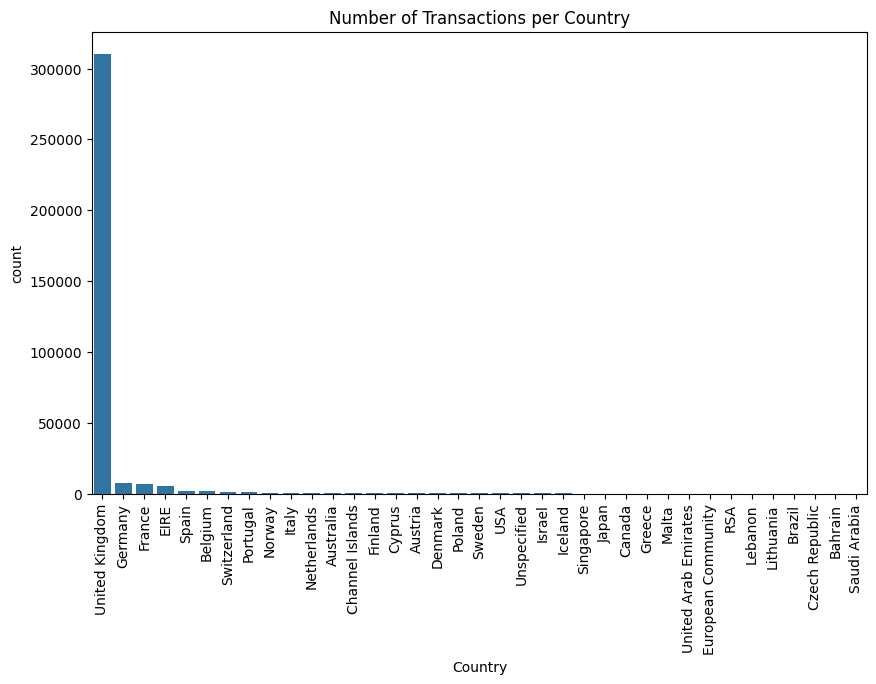

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Country', data=df, order=df['Country'].value_counts().index)
plt.xticks(rotation=90)
plt.title("Number of Transactions per Country")
plt.show()

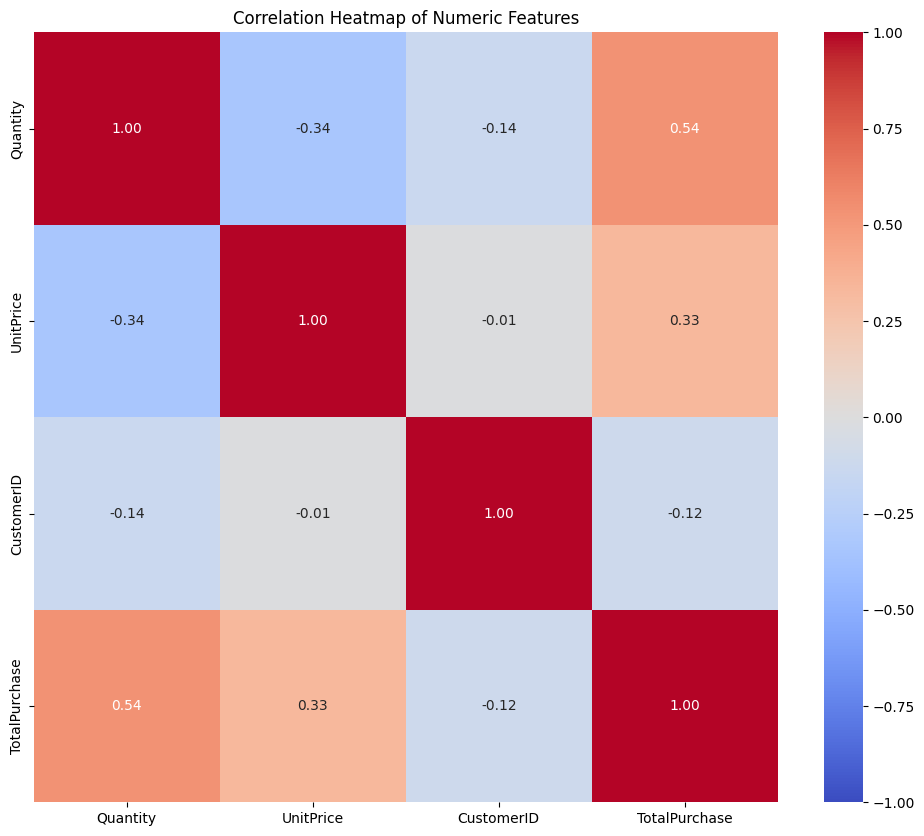

In [ ]:
# Filter numeric columns for correlation heatmap
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[numeric_cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

# Andvanced Feature Engineering

**Rolling Sums:**

* **TotalOrdersLast1Week:** Sum of orders in the past 7 days for each customer.
* **TotalAmountLast1Week:** Sum of purchase amounts in the past 7 days for each customer.
* **TotalOrdersLast1Month:** Sum of orders in the past 30 days for each customer.
* **TotalAmountLast1Month**: Sum of purchase amounts in the past 30 days for each customer.

**Time-Based Features:**

* **TimeSinceLastOrder:** Time in days since the last order for each customer.
* **DaysSinceFirstPurchase:** Days since the first purchase for each customer.

**Aggregate Purchase Amounts:**

* **MaxAmountLast30Days**: Maximum purchase amount in the past 30 days for each customer.
* **MaxOrderAmount:** Maximum purchase amount ever for each customer.
* **MinAmountPriorToDate**: Minimum purchase amount ever for each customer.
* **MeanAmountPriorToDate**: Mean purchase amount ever for each customer.

**Order Statistics:**

* **MinOrderAmount:** Minimum unit price ever for each customer.
* **PrevMeanAmount:** Mean purchase amount in the past 30 days for each customer.
* **AverageOrderAmount:** Mean unit price ever for each customer.
* **TotalUniqueOrders:** Total unique orders for each customer.
* **PreviousStdDevTotalOrderAmount:** Standard deviation of total purchase amount in the past 30 days for each customer.
* **OrderStdDeviation:** Standard deviation of order quantities for each customer.

**Customer Activity:**
* **CumulativeTime:** Cumulative time in days since the last order for each customer.
* **PriorOrderCount:** Count of prior orders for each customer.
* **AverageOrderDuration:** Average duration between orders for each customer.

**Churn Indicator:**

* **Churn:** Binary indicator of customer churn based on a 30-day inactivity threshold.

In [ ]:
# Feature Engineering
df['TotalOrdersLast1Week'] = df.groupby('CustomerID')['Quantity'].transform(lambda x: x.rolling(window=7, min_periods=1).sum())
df['TotalAmountLast1Week'] = df.groupby('CustomerID')['TotalPurchase'].transform(lambda x: x.rolling(window=7, min_periods=1).sum())
df['TimeSinceLastOrder'] = df.groupby('CustomerID')['InvoiceDate'].diff().dt.total_seconds() / (60 * 60 * 24)
df['TotalOrdersLast1Month'] = df.groupby('CustomerID')['Quantity'].transform(lambda x: x.rolling(window=30, min_periods=1).sum())
df['TotalAmountLast1Month'] = df.groupby('CustomerID')['TotalPurchase'].transform(lambda x: x.rolling(window=30, min_periods=1).sum())
df['MaxAmountLast30Days'] = df.groupby('CustomerID')['TotalPurchase'].transform(lambda x: x.rolling(window=30, min_periods=1).max())
df['MaxOrderAmount'] = df.groupby('CustomerID')['UnitPrice'].transform(lambda x: x.expanding().max())
df['MinAmountPriorToDate'] = df.groupby('CustomerID')['TotalPurchase'].transform(lambda x: x.expanding().min())
df['MeanAmountPriorToDate'] = df.groupby('CustomerID')['TotalPurchase'].transform(lambda x: x.expanding().mean())
df['MinOrderAmount'] = df.groupby('CustomerID')['UnitPrice'].transform('min')
df['PrevMeanAmount'] = df.groupby('CustomerID')['TotalAmountLast1Month'].transform(lambda x: x.expanding().mean())
df['CumulativeTime'] = df.groupby('CustomerID')['TimeSinceLastOrder'].cumsum()
df['PriorOrderCount'] = df.groupby('CustomerID').cumcount()
df['AverageOrderDuration'] = df['CumulativeTime'] / (df['PriorOrderCount'] + 1)  # Avoid division by zero
df['AverageOrderAmount'] = df.groupby('CustomerID')['UnitPrice'].transform('mean')
df['TotalUniqueOrders'] = df.groupby('CustomerID')['InvoiceNo'].transform('nunique')
df['DaysSinceFirstPurchase'] = (df['InvoiceDate'] - df.groupby('CustomerID')['InvoiceDate'].transform('min')).dt.days
df['PreviousStdDevTotalOrderAmount'] = df.groupby('CustomerID')['TotalPurchase'].transform(lambda x: x.rolling(window=30).std())
df['OrderStdDeviation'] = df.groupby('CustomerID')['Quantity'].transform('std')

# Binary churn column
churn_threshold = 30
df['Churn'] = df.groupby('CustomerID')['DaysSinceFirstPurchase'].transform(lambda x: (x.max() > churn_threshold).astype(int))

# Add encoded 'CountryCode' feature
df['CountryCode'] = df['Country'].astype('category').cat.codes

# Print data after feature engineering
print("Data After Feature Engineering:")
print(df.head())


# Summary statistics for new features
print("Feature Engineering Summary:")
print(df.describe())

Data After Feature Engineering:
      InvoiceNo StockCode                          Description  Quantity  \
14938    537626     85116      BLACK CANDELABRA T-LIGHT HOLDER        12   
14939    537626     22375    AIRLINE BAG VINTAGE JET SET BROWN         4   
14940    537626     71477    COLOUR GLASS. STAR T-LIGHT HOLDER        12   
14942    537626     22771  CLEAR DRAWER KNOB ACRYLIC EDWARDIAN        12   
14943    537626     22772   PINK DRAWER KNOB ACRYLIC EDWARDIAN        12   

              InvoiceDate  UnitPrice  CustomerID  Country  TotalPurchase  \
14938 2010-12-07 14:57:00       2.10       12347  Iceland           25.2   
14939 2010-12-07 14:57:00       4.25       12347  Iceland           17.0   
14940 2010-12-07 14:57:00       3.25       12347  Iceland           39.0   
14942 2010-12-07 14:57:00       1.25       12347  Iceland           15.0   
14943 2010-12-07 14:57:00       1.25       12347  Iceland           15.0   

       TotalOrdersLast1Week  ...  CumulativeTime  Prio

In [ ]:
print("Missing Values Summary:")
print(df.isnull().sum())

Missing Values Summary:
InvoiceNo                             0
StockCode                             0
Description                           0
Quantity                              0
InvoiceDate                           0
UnitPrice                             0
CustomerID                            0
Country                               0
TotalPurchase                         0
TotalOrdersLast1Week                  0
TotalAmountLast1Week                  0
TimeSinceLastOrder                 4222
TotalOrdersLast1Month                 0
TotalAmountLast1Month                 0
MaxAmountLast30Days                   0
MaxOrderAmount                        0
MinAmountPriorToDate                  0
MeanAmountPriorToDate                 0
MinOrderAmount                        0
PrevMeanAmount                        0
CumulativeTime                     4222
PriorOrderCount                       0
AverageOrderDuration               4222
AverageOrderAmount                    0
TotalUniqueOrder

In [ ]:
from sklearn.impute import SimpleImputer

# Define imputers for numerical and categorical features
num_features = df.select_dtypes(include=[np.number]).columns.tolist()
cat_features = df.select_dtypes(include=[object]).columns.tolist()

# Impute numerical features using median
num_imputer = SimpleImputer(strategy='median')
df[num_features] = num_imputer.fit_transform(df[num_features])

# Impute categorical features using mode
cat_imputer = SimpleImputer(strategy='most_frequent')
df[cat_features] = cat_imputer.fit_transform(df[cat_features])

# Check for remaining missing values
print("\nMissing Values After Imputation:")
print(df.isnull().sum())


Missing Values After Imputation:
InvoiceNo                         0
StockCode                         0
Description                       0
Quantity                          0
InvoiceDate                       0
UnitPrice                         0
CustomerID                        0
Country                           0
TotalPurchase                     0
TotalOrdersLast1Week              0
TotalAmountLast1Week              0
TimeSinceLastOrder                0
TotalOrdersLast1Month             0
TotalAmountLast1Month             0
MaxAmountLast30Days               0
MaxOrderAmount                    0
MinAmountPriorToDate              0
MeanAmountPriorToDate             0
MinOrderAmount                    0
PrevMeanAmount                    0
CumulativeTime                    0
PriorOrderCount                   0
AverageOrderDuration              0
AverageOrderAmount                0
TotalUniqueOrders                 0
DaysSinceFirstPurchase            0
PreviousStdDevTotalOrderAmount

In [ ]:
# Dropped features with excessive missing values
threshold = 0.8  # threshold
missing_proportion = df.isnull().mean()
features_to_drop = missing_proportion[missing_proportion > threshold].index
df = df.drop(columns=features_to_drop)

print(f"\nDropped Features with High Missing Values: {features_to_drop.tolist()}")


Dropped Features with High Missing Values: []


In [ ]:
print("\nData Summary After Imputation:")
print(df.describe(include='all'))


Data Summary After Imputation:
       InvoiceNo StockCode                         Description       Quantity  \
count     344393    344393                              344393  344393.000000   
unique     19480      3415                                3598            NaN   
top       576339    85123A  WHITE HANGING HEART T-LIGHT HOLDER            NaN   
freq         460      1724                                1718            NaN   
mean         NaN       NaN                                 NaN       7.279797   
min          NaN       NaN                                 NaN     -13.000000   
25%          NaN       NaN                                 NaN       2.000000   
50%          NaN       NaN                                 NaN       5.000000   
75%          NaN       NaN                                 NaN      12.000000   
max          NaN       NaN                                 NaN      27.000000   
std          NaN       NaN                                 NaN       6.880816

# EDA on featured engineered

In [ ]:
# Check for categorical features
categorical_features = df.select_dtypes(include=['object', 'category']).columns
print("Categorical Features:", categorical_features)

# Check for numerical features
numerical_features = df.select_dtypes(include=['number']).columns
print("Numerical Features:", numerical_features)

Categorical Features: Index(['InvoiceNo', 'StockCode', 'Description', 'Country'], dtype='object')
Numerical Features: Index(['Quantity', 'UnitPrice', 'CustomerID', 'TotalPurchase',
       'TotalOrdersLast1Week', 'TotalAmountLast1Week', 'TimeSinceLastOrder',
       'TotalOrdersLast1Month', 'TotalAmountLast1Month', 'MaxAmountLast30Days',
       'MaxOrderAmount', 'MinAmountPriorToDate', 'MeanAmountPriorToDate',
       'MinOrderAmount', 'PrevMeanAmount', 'CumulativeTime', 'PriorOrderCount',
       'AverageOrderDuration', 'AverageOrderAmount', 'TotalUniqueOrders',
       'DaysSinceFirstPurchase', 'PreviousStdDevTotalOrderAmount',
       'OrderStdDeviation', 'Churn', 'CountryCode'],
      dtype='object')


In [ ]:
# Checking for negative values in numerical features
def check_negative_values(df, features):
    negative_counts = {}
    for feature in features:
        negative_counts[feature] = (df[feature] < 0).sum()
    return negative_counts

numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
negative_counts = check_negative_values(df, numerical_features)
print("Negative Values Count:")
for feature, count in negative_counts.items():
    print(f"{feature}: {count}")

# Handling negative values
def handle_negative_values(df, features):
    for feature in features:
        df[feature] = df[feature].clip(lower=0)  # Replace negative values with 0
    return df

df = handle_negative_values(df, numerical_features)

Negative Values Count:
Quantity: 6211
UnitPrice: 0
CustomerID: 0
TotalPurchase: 6211
TotalOrdersLast1Week: 2001
TotalAmountLast1Week: 2257
TimeSinceLastOrder: 0
TotalOrdersLast1Month: 837
TotalAmountLast1Month: 910
MaxAmountLast30Days: 408
MaxOrderAmount: 0
MinAmountPriorToDate: 125231
MeanAmountPriorToDate: 406
MinOrderAmount: 0
PrevMeanAmount: 527
CumulativeTime: 0
PriorOrderCount: 0
AverageOrderDuration: 0
AverageOrderAmount: 0
TotalUniqueOrders: 0
DaysSinceFirstPurchase: 0
PreviousStdDevTotalOrderAmount: 0
OrderStdDeviation: 0
Churn: 0
CountryCode: 0


In [ ]:
from scipy.stats import iqr

def print_outliers(df, features):
    outlier_counts = {}
    for feature in features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR_value = iqr(df[feature].dropna())
        lower_bound = Q1 - 1.5 * IQR_value
        upper_bound = Q3 + 1.5 * IQR_value
        outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
        outlier_counts[feature] = outliers.shape[0]
    print("\nOutliers Count:")
    for feature, count in outlier_counts.items():
        print(f"{feature}: {count}")

# outliers before handling
print_outliers(df, numerical_features)


Outliers Count:
Quantity: 0
UnitPrice: 15853
CustomerID: 0
TotalPurchase: 13592
TotalOrdersLast1Week: 2011
TotalAmountLast1Week: 7989
TimeSinceLastOrder: 15168
TotalOrdersLast1Month: 636
TotalAmountLast1Month: 4998
MaxAmountLast30Days: 24869
MaxOrderAmount: 8671
MinAmountPriorToDate: 18929
MeanAmountPriorToDate: 5913
MinOrderAmount: 16253
PrevMeanAmount: 5473
CumulativeTime: 0
PriorOrderCount: 39398
AverageOrderDuration: 24790
AverageOrderAmount: 12262
TotalUniqueOrders: 34899
DaysSinceFirstPurchase: 0
PreviousStdDevTotalOrderAmount: 33303
OrderStdDeviation: 553
Churn: 40112
CountryCode: 33967


In [ ]:
# Define functions for handling data
def handle_negative_values(df, features):
    for feature in features:
        df[feature] = df[feature].clip(lower=0)
    return df

def cap_outliers(df, features, lower_percentile=1, upper_percentile=99):
    for feature in features:
        lower_bound = df[feature].quantile(lower_percentile / 100)
        upper_bound = df[feature].quantile(upper_percentile / 100)
        df[feature] = np.clip(df[feature], lower_bound, upper_bound)
    return df

# Handling negative values
df = handle_negative_values(df, numerical_features)

# Handling outliers
df = cap_outliers(df, numerical_features)

In [ ]:
# Check the number of unique categories in each categorical feature
for feature in categorical_features:
    print(f'{feature}: {df[feature].nunique()} unique values')

InvoiceNo: 19480 unique values
StockCode: 3415 unique values
Description: 3598 unique values
Country: 37 unique values


In [ ]:
def plot_categorical_features(df, features, max_categories=20):
    cat_features = len(features)
    cols = 3
    rows = (cat_features + cols - 1) // cols

    plt.figure(figsize=(cols * 5, rows * 5))
    for i, feature in enumerate(features):
        plt.subplot(rows, cols, i + 1)
        data = df[feature].value_counts()
        if len(data) > max_categories:
            data = data[:max_categories]
        sns.barplot(x=data.index, y=data.values)
        plt.title(f'{feature}')
        plt.xlabel('')
        plt.ylabel('Count')
        plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()



Categorical Features: Index(['InvoiceNo', 'StockCode', 'Description', 'Country'], dtype='object')


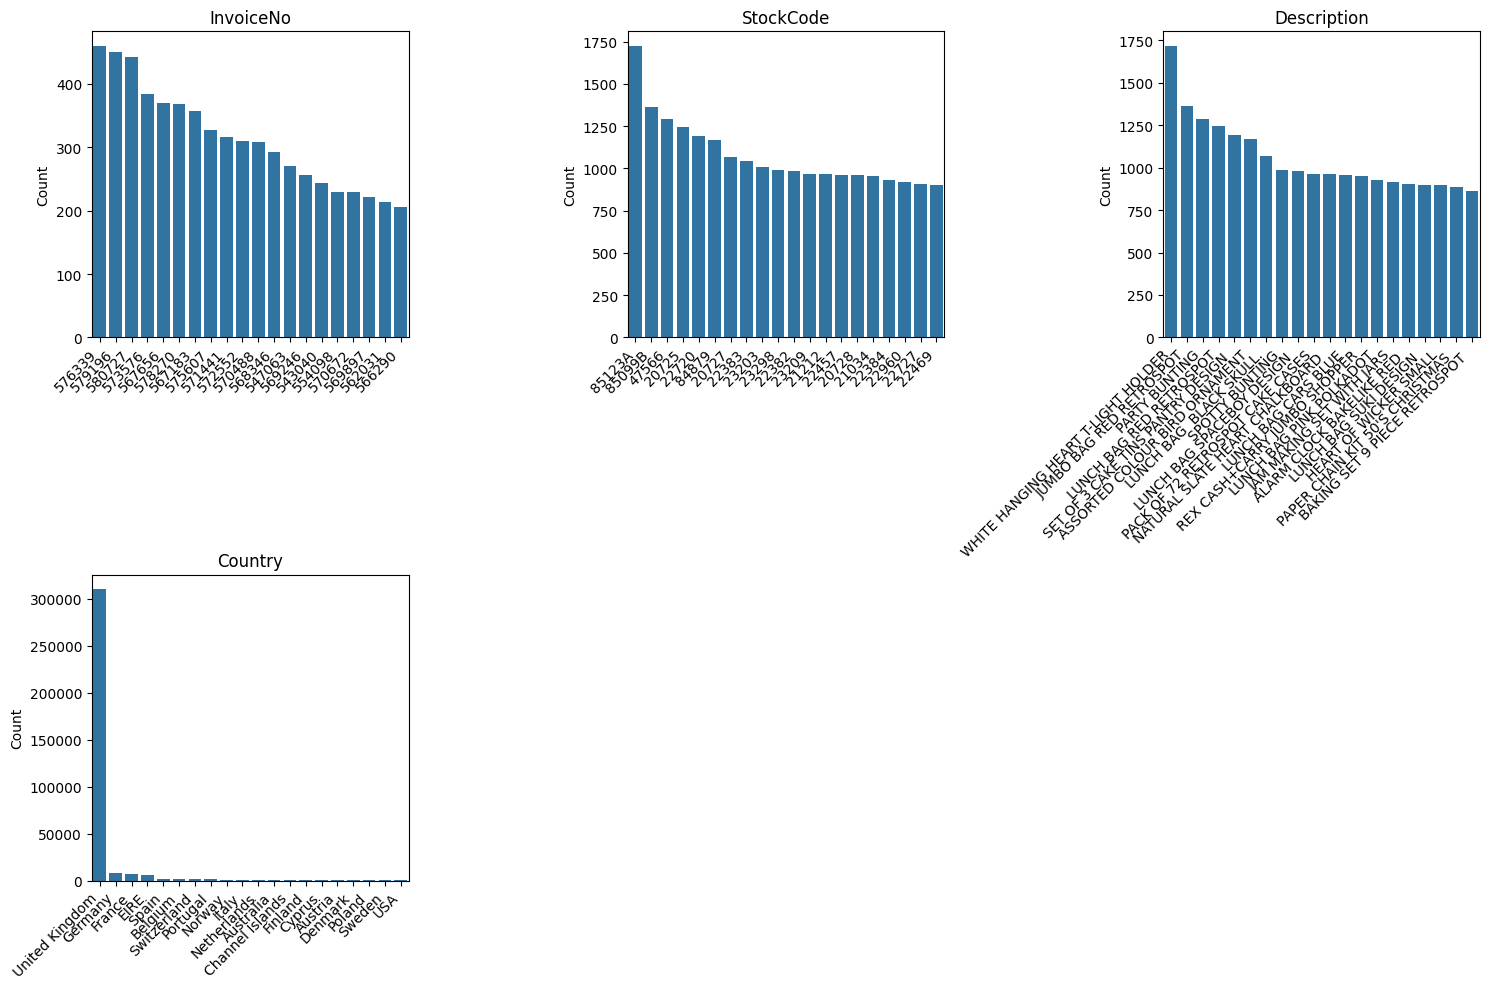

In [ ]:
# Extract categorical features
categorical_features = df.select_dtypes(include=['object', 'category']).columns
print("Categorical Features:", categorical_features)

# Plot categorical features
plot_categorical_features(df, categorical_features)

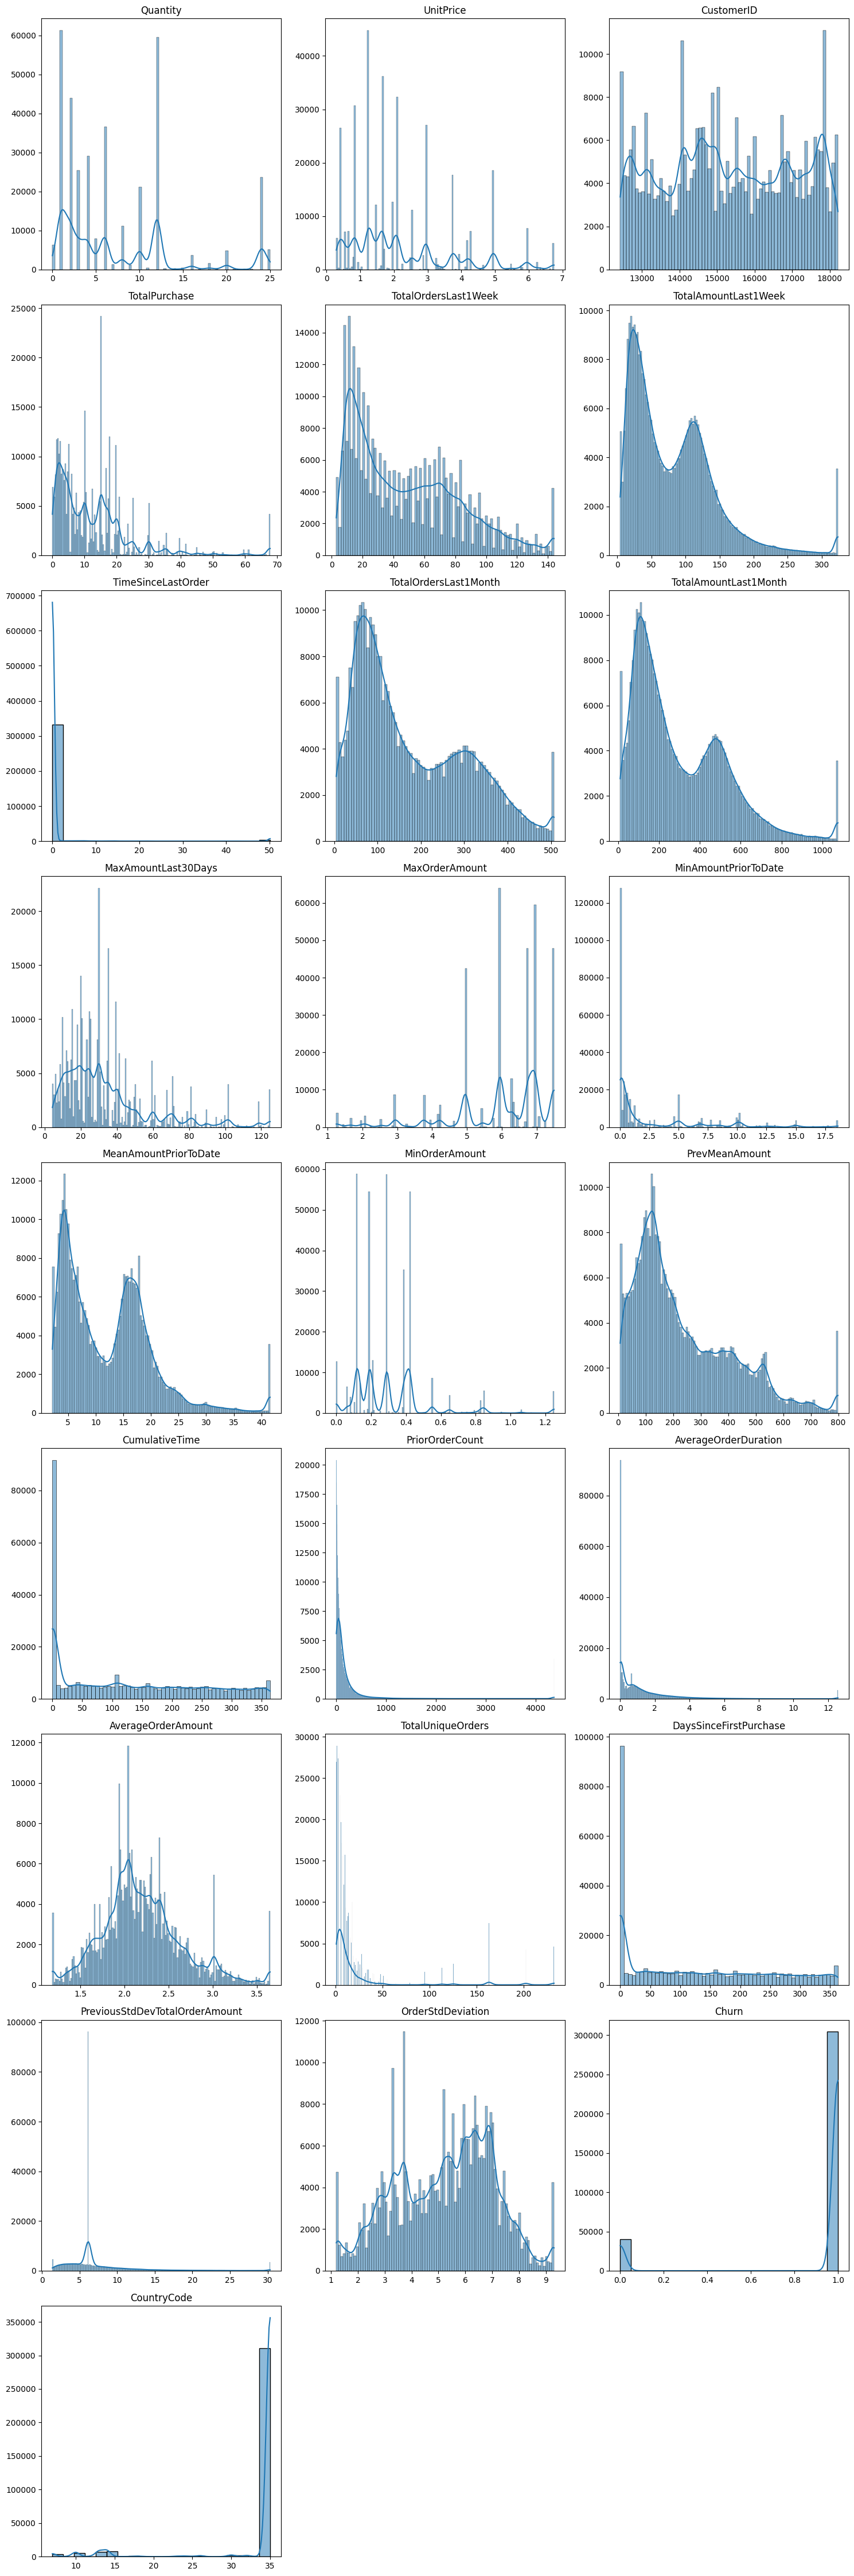

In [ ]:
# function to plot numerical features
def plot_numerical_features(df, features):
    num_features = len(features)
    cols = 3
    rows = (num_features + cols - 1) // cols

    plt.figure(figsize=(cols * 5, rows * 5))
    for i, feature in enumerate(features):
        plt.subplot(rows, cols, i + 1)
        sns.histplot(df[feature], kde=True)
        plt.title(f'{feature}')
        plt.xlabel('')
        plt.ylabel('')

    plt.tight_layout()
    plt.show()

# Extract numerical features
numerical_features = df.select_dtypes(include=['number']).columns

# Plot numerical features
plot_numerical_features(df, numerical_features)

In [ ]:
def plot_boxplots(df, features):
    num_features = len(features)
    cols = 3
    rows = (num_features + cols - 1) // cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
    axes = axes.flatten()  # Flatten the 2D array of axes to make indexing easier

    for i, feature in enumerate(features):
        sns.boxplot(x=df[feature], ax=axes[i])
        axes[i].set_title(f'Boxplot of {feature}')
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')

    # Hide any unused subplots
    for j in range(num_features, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

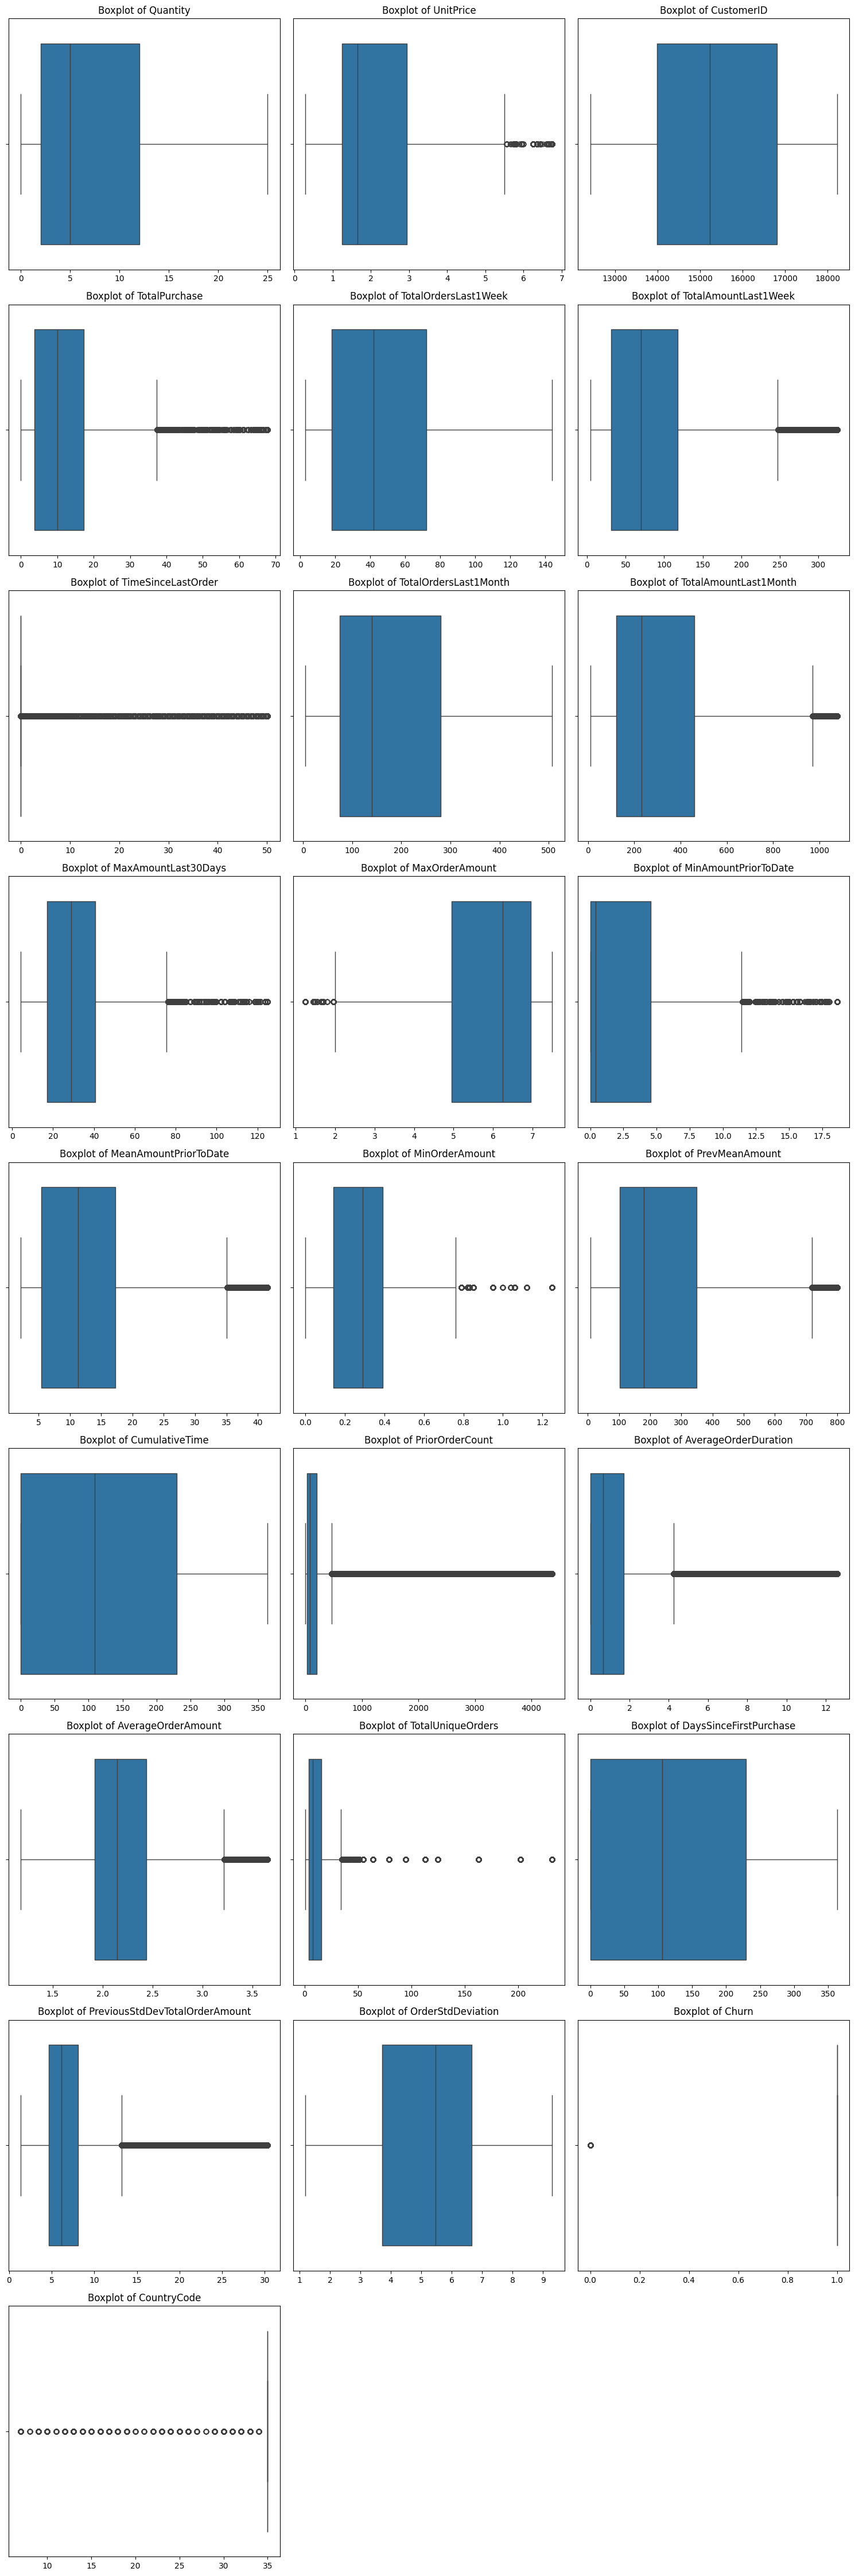

In [ ]:
# Plot boxplots for numerical features
plot_boxplots(df, numerical_features)

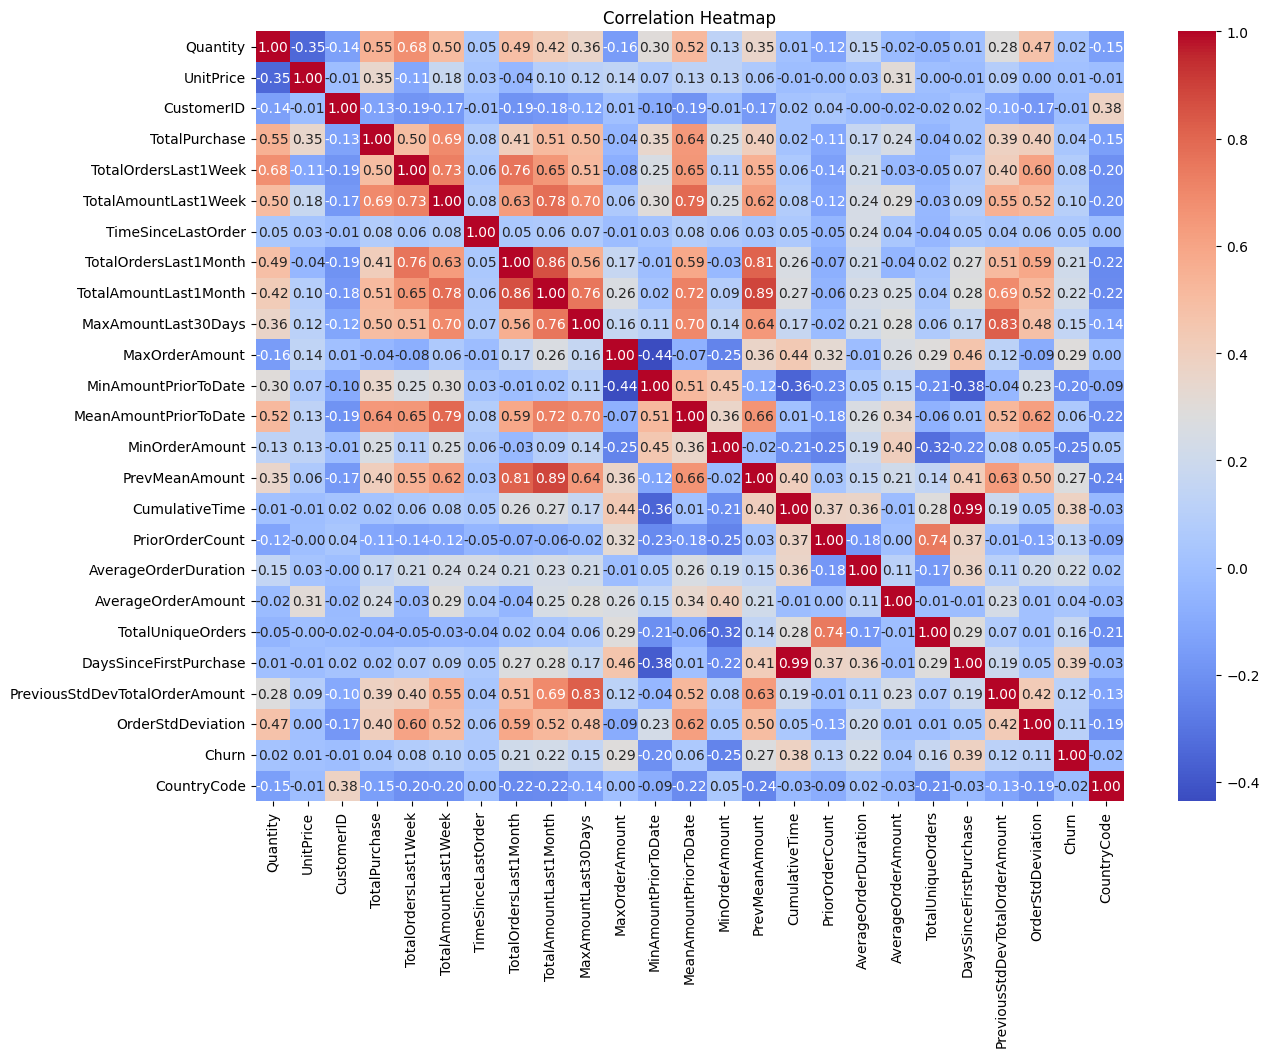

In [ ]:
# EDA: Correlation heatmap
def plot_correlation_heatmap(df, features):
    plt.figure(figsize=(14, 10))
    corr = df[features].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap')
    plt.show()

# Plot correlation heatmap for numerical features
plot_correlation_heatmap(df, numerical_features)


In [ ]:
churn_counts = df['Churn'].value_counts()
print(f"Churn Counts:\n{churn_counts}")

Churn Counts:
Churn
1.0    304281
0.0     40112
Name: count, dtype: int64


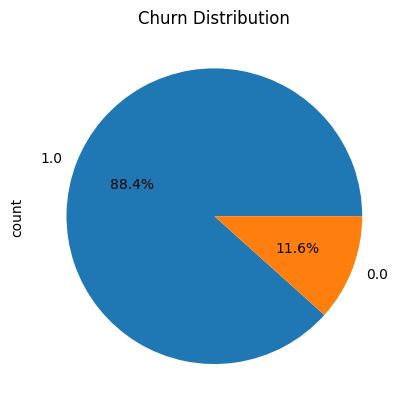

In [ ]:
import matplotlib.pyplot as plt

churn_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('Churn Distribution')
plt.show()

The churn distribution shows a significant imbalance:

	•	Churn (1): 304,281 instances
	•	No Churn (0): 40,112 instances

This indicates that the churn class is much more prevalent than the non-churn class.

In [ ]:
# Function to check dataset size
def check_dataset_size(df):
    # Get number of samples and features
    num_samples, num_features = df.shape

    # Calculate memory usage in megabytes
    memory_usage_mb = df.memory_usage(deep=True).sum() / (1024 ** 2)

    # Determine size category
    if num_samples < 10000:
        size_category = "small"
    elif num_samples < 1000000:
        size_category = "medium"
    else:
        size_category = "large"

    # Print summary
    print(f"Number of samples: {num_samples}")
    print(f"Number of features: {num_features}")
    print(f"Memory usage: {memory_usage_mb:.2f} MB")
    print(f"Dataset size category: {size_category}")

# Call the function
check_dataset_size(df)

Number of samples: 344393
Number of features: 30
Memory usage: 162.65 MB
Dataset size category: medium


# Data Preparation and Splitting

In [ ]:
# Define features and target
X = df.drop(['Churn', 'InvoiceDate', 'InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Country'], axis=1)
y = df['Churn']

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Further split training data for validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Preprocessing Numerical Features



In [ ]:
# Define preprocessing for numerical features
numerical_features = X.select_dtypes(include=['number']).columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features)
    ])

# Define Models & Pipelines

**Baseline Pipeline (Logistic Regression)**

In [ ]:
from imblearn.pipeline import Pipeline as imbPipeline

Logistic Regression Training Time: 7.61 seconds
Logistic Regression Baseline Model:
              precision    recall  f1-score   support

         0.0       0.80      0.86      0.83     12137
         1.0       0.98      0.97      0.98     91181

    accuracy                           0.96    103318
   macro avg       0.89      0.91      0.90    103318
weighted avg       0.96      0.96      0.96    103318

ROC-AUC Score: 0.9876218052518437
F1 Score: 0.9758084518842288
Recall Score: 0.9708053212840394
Percent Churn: 87.35%


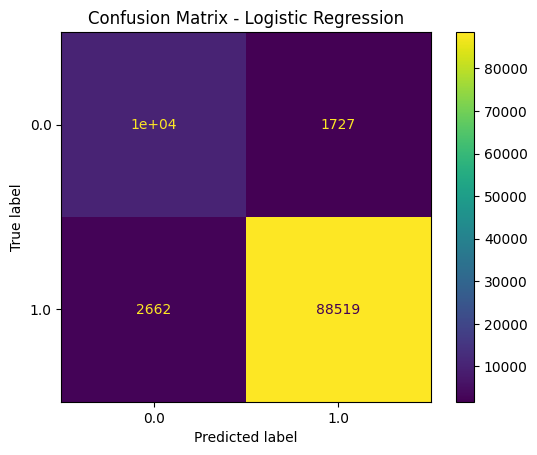

In [ ]:
#Training Logistic Regression baseline model
pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Training the Logistic Regression model
start_time_lr = time.time()
pipeline_lr.fit(X_train, y_train)
end_time_lr = time.time()
training_time_lr = end_time_lr - start_time_lr
print(f"Logistic Regression Training Time: {training_time_lr:.2f} seconds")

# Predict and evaluate Logistic Regression
y_pred_lr = pipeline_lr.predict(X_test)
y_pred_proba_lr = pipeline_lr.predict_proba(X_test)

print("Logistic Regression Baseline Model:")
print(classification_report(y_test, y_pred_lr))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_lr[:, 1])}")
print(f"F1 Score: {f1_score(y_test, y_pred_lr)}")
print(f"Recall Score: {recall_score(y_test, y_pred_lr)}")
print(f"Percent Churn: {np.mean(y_pred_lr) * 100:.2f}%")

# Plot confusion matrix for Logistic Regression
ConfusionMatrixDisplay.from_estimator(pipeline_lr, X_test, y_test)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, f1_score, recall_score, confusion_matrix
# Print confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
print("Confusion Matrix for Logistic Regression:")
print(cm_lr)




Confusion Matrix for Logistic Regression:
[[10410  1727]
 [ 2662 88519]]


# Random Forest and XGBoost Model Pipelines

**Random Forest Model**

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Random Forest Training Time: 2074.24 seconds
Random Forest Model:
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96     12137
         1.0       1.00      0.99      0.99     91181

    accuracy                           0.99    103318
   macro avg       0.96      0.99      0.98    103318
weighted avg       0.99      0.99      0.99    103318

ROC-AUC Score: 0.9996172423809759
F1 Score: 0.9941298912983623
Recall Score: 0.9899650146412081
Percent Churn: 87.51%


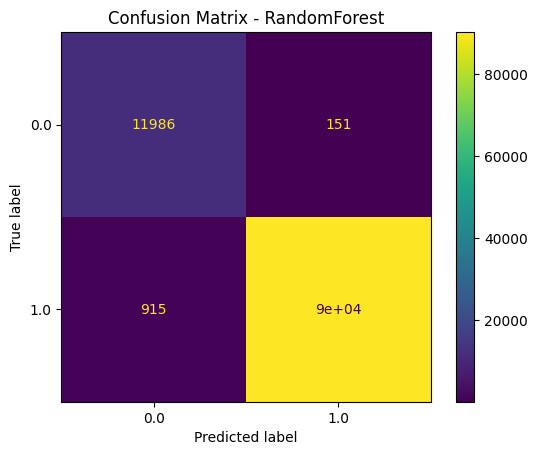

Confusion Matrix RandomForest:
[[11986   151]
 [  915 90266]]


In [ ]:
# Define Stratified K-Fold cross-validator
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define pipeline for RandomForest with SMOTE
pipeline_rf = ImbalancedPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Parameter grid for RandomForest
param_grid_rf = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [10, 20],
    'classifier__max_features': ['sqrt'],
    'classifier__min_samples_split': [2, 5]
}

# GridSearchCV for RandomForest with Stratified K-Fold
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=stratified_kfold, verbose=1, n_jobs=-1)

# Train the RandomForest model
start_time_rf = time.time()
grid_search_rf.fit(X_train, y_train)
end_time_rf = time.time()
training_time_rf = end_time_rf - start_time_rf
print(f"Random Forest Training Time: {training_time_rf:.2f} seconds")

# Predict and evaluate RandomForest with best estimator
best_rf_model = grid_search_rf.best_estimator_

y_pred_rf = best_rf_model.predict(X_test)
y_pred_proba_rf = best_rf_model.predict_proba(X_test)

print("Random Forest Model:")
print(classification_report(y_test, y_pred_rf))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_rf[:, 1])}")
print(f"F1 Score: {f1_score(y_test, y_pred_rf)}")
print(f"Recall Score: {recall_score(y_test, y_pred_rf)}")
print(f"Percent Churn: {np.mean(y_pred_rf) * 100:.2f}%")

# Plot confusion matrix for RandomForest
conf_matrix_rf = ConfusionMatrixDisplay.from_estimator(best_rf_model, X_test, y_test)
plt.title("Confusion Matrix - RandomForest")
plt.show()

# Print confusion matrix
print("Confusion Matrix RandomForest:")
print(conf_matrix_rf.confusion_matrix)

In [ ]:
# Print confusion matrix
print("Confusion Matrix RandomForest:")
print(conf_matrix_rf.confusion_matrix)

Confusion Matrix RandomForest:
[[11986   151]
 [  915 90266]]


**XGBoost Model**

Fitting 5 folds for each of 10 candidates, totalling 50 fits
XGBoost Training Time: 251.61 seconds
XGBoost Model:
              precision    recall  f1-score   support

         0.0       0.86      0.98      0.92     12137
         1.0       1.00      0.98      0.99     91181

    accuracy                           0.98    103318
   macro avg       0.93      0.98      0.95    103318
weighted avg       0.98      0.98      0.98    103318

ROC-AUC Score: 0.9987895714094639
F1 Score: 0.9883345139011864
Recall Score: 0.9793487678354043
Percent Churn: 86.65%


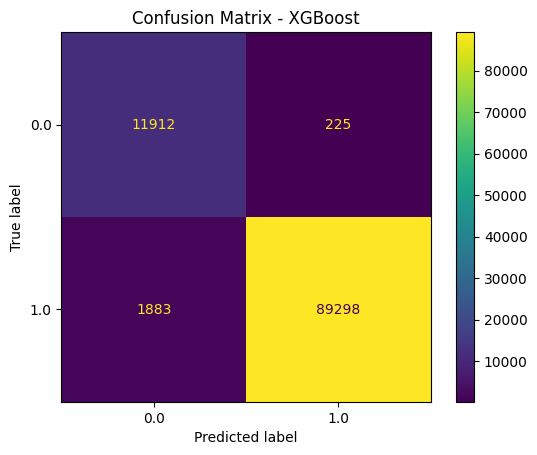

Confusion Matrix XGBoost:
[[11912   225]
 [ 1883 89298]]


In [ ]:

# Define Stratified K-Fold cross-validator
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define pipeline for XGBoost with SMOTE
pipeline_xgb = ImbalancedPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(random_state=42, eval_metric='logloss'))  # Ensure eval_metric is set properly
])

# Parameter grid for XGBoost
param_dist_xgb = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [3, 6],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0]
}

# RandomizedSearchCV for XGBoost with Stratified K-Fold
random_search_xgb = RandomizedSearchCV(pipeline_xgb, param_distributions=param_dist_xgb,
                                        n_iter=10, cv=stratified_kfold, verbose=1, n_jobs=-1,
                                        random_state=42)

# Train the XGBoost model
start_time_xgb = time.time()
random_search_xgb.fit(X_train, y_train)
end_time_xgb = time.time()
training_time_xgb = end_time_xgb - start_time_xgb
print(f"XGBoost Training Time: {training_time_xgb:.2f} seconds")

# Predict and evaluate XGBoost with best estimator
best_xgb_model = random_search_xgb.best_estimator_

y_pred_xgb = best_xgb_model.predict(X_test)
y_pred_proba_xgb = best_xgb_model.predict_proba(X_test)

print("XGBoost Model:")
print(classification_report(y_test, y_pred_xgb))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_xgb[:, 1])}")
print(f"F1 Score: {f1_score(y_test, y_pred_xgb)}")
print(f"Recall Score: {recall_score(y_test, y_pred_xgb)}")
print(f"Percent Churn: {np.mean(y_pred_xgb) * 100:.2f}%")

# Plot and print confusion matrix for XGBoost
conf_matrix_xgb = ConfusionMatrixDisplay.from_estimator(best_xgb_model, X_test, y_test)
plt.title("Confusion Matrix - XGBoost")
plt.show()

print("Confusion Matrix XGBoost:")
print(conf_matrix_xgb.confusion_matrix)

# Feature Importance for Random Forest and XGBoost

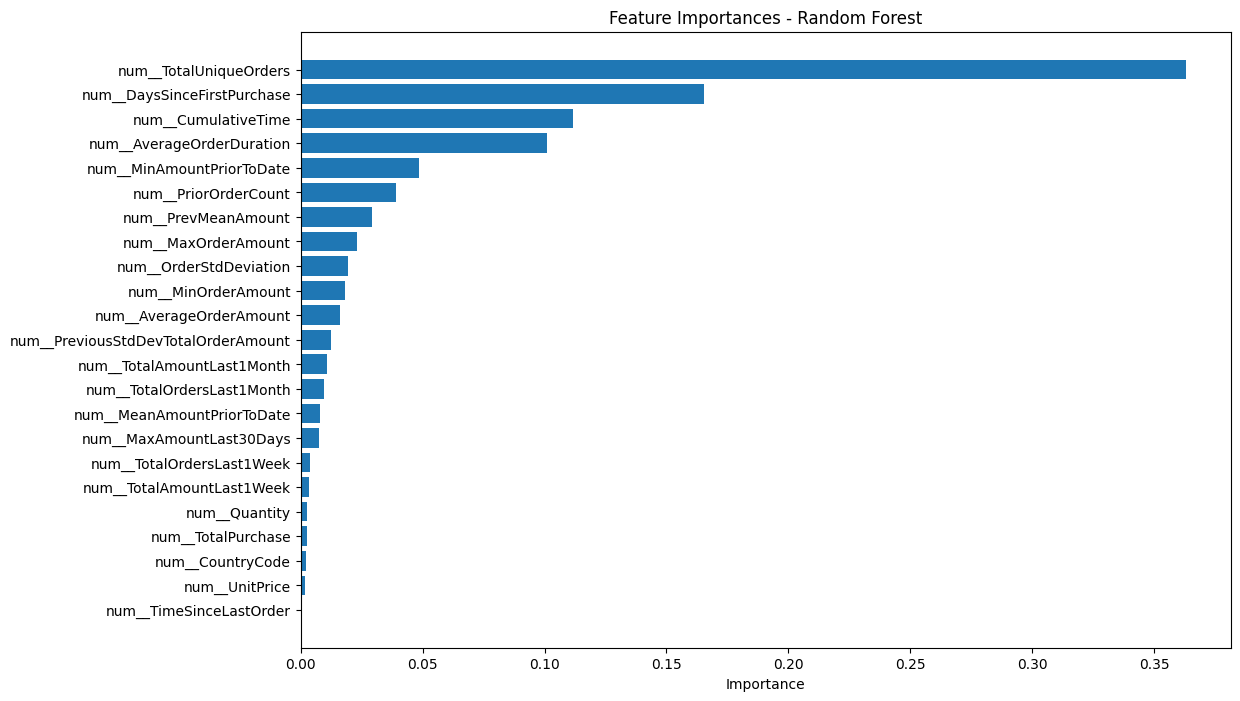

                                Feature  Importance
18               num__TotalUniqueOrders    0.363132
19          num__DaysSinceFirstPurchase    0.165321
14                  num__CumulativeTime    0.111637
16            num__AverageOrderDuration    0.101100
10            num__MinAmountPriorToDate    0.048467
15                 num__PriorOrderCount    0.039169
13                  num__PrevMeanAmount    0.029128
9                   num__MaxOrderAmount    0.023056
21               num__OrderStdDeviation    0.019575
12                  num__MinOrderAmount    0.018395
17              num__AverageOrderAmount    0.016000
20  num__PreviousStdDevTotalOrderAmount    0.012651
7            num__TotalAmountLast1Month    0.010905
6            num__TotalOrdersLast1Month    0.009422
11           num__MeanAmountPriorToDate    0.008133
8              num__MaxAmountLast30Days    0.007503
3             num__TotalOrdersLast1Week    0.003771
4             num__TotalAmountLast1Week    0.003295
0           

In [ ]:

# Extract the best Random Forest model
best_rf_model = grid_search_rf.best_estimator_

# feature importances from the best Random Forest model
rf_importances = best_rf_model.named_steps['classifier'].feature_importances_

# Create a DataFrame for feature importances
features = preprocessor.get_feature_names_out()
rf_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': rf_importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(rf_importance_df['Feature'], rf_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances - Random Forest')
plt.gca().invert_yaxis()
plt.show()

# Print feature importances
print(rf_importance_df)

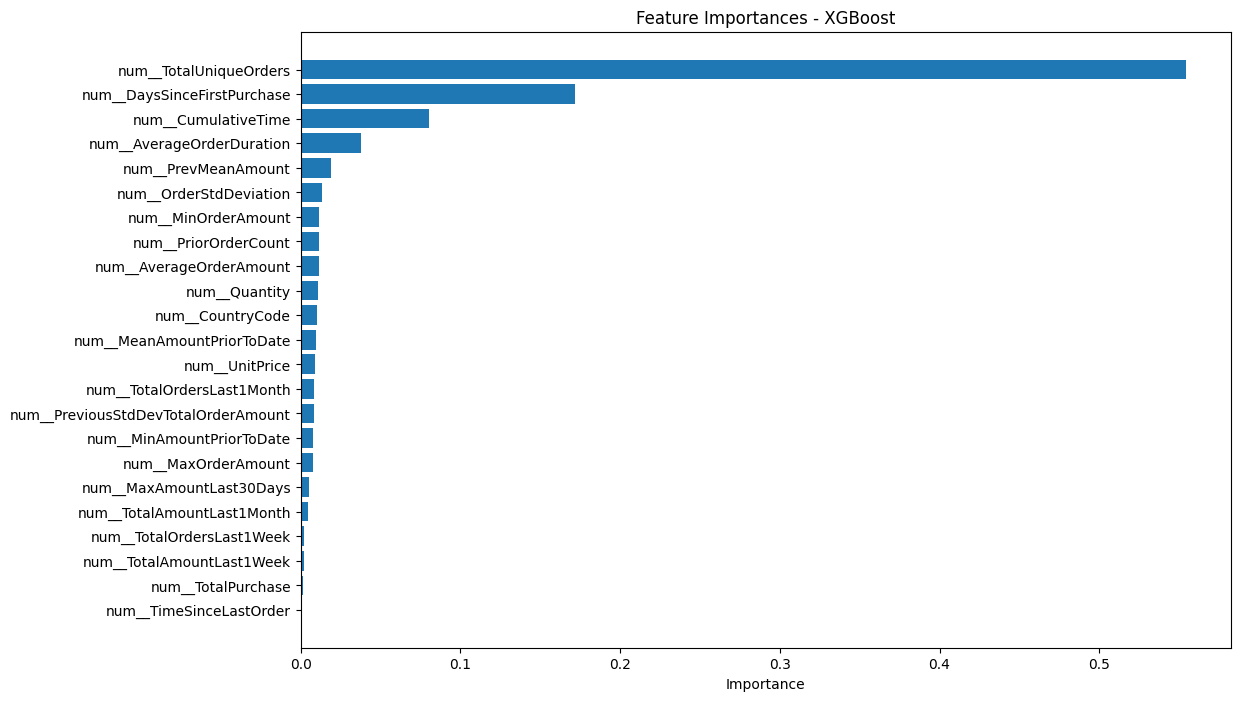

                                Feature  Importance
18               num__TotalUniqueOrders    0.554489
19          num__DaysSinceFirstPurchase    0.171985
14                  num__CumulativeTime    0.080233
16            num__AverageOrderDuration    0.037723
13                  num__PrevMeanAmount    0.019170
21               num__OrderStdDeviation    0.013592
12                  num__MinOrderAmount    0.011675
15                 num__PriorOrderCount    0.011631
17              num__AverageOrderAmount    0.011378
0                         num__Quantity    0.011073
22                     num__CountryCode    0.010153
11           num__MeanAmountPriorToDate    0.009370
1                        num__UnitPrice    0.009307
6            num__TotalOrdersLast1Month    0.008482
20  num__PreviousStdDevTotalOrderAmount    0.008311
10            num__MinAmountPriorToDate    0.007664
9                   num__MaxOrderAmount    0.007532
8              num__MaxAmountLast30Days    0.004983
7           

In [ ]:
# Extract the best XGBoost model
best_xgb_model = random_search_xgb.best_estimator_

# Get feature importances from the best XGBoost model
xgb_importances = best_xgb_model.named_steps['classifier'].feature_importances_

# Create a DataFrame for feature importances
features = preprocessor.get_feature_names_out()
xgb_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': xgb_importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(xgb_importance_df['Feature'], xgb_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances - XGBoost')
plt.gca().invert_yaxis()
plt.show()

# Print feature importances
print(xgb_importance_df)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 26.0 MB/s eta 0:00:00
Performing SHAP analysis for XGBoost...


 99%|===================| 102339/103318 [01:05<00:00]       

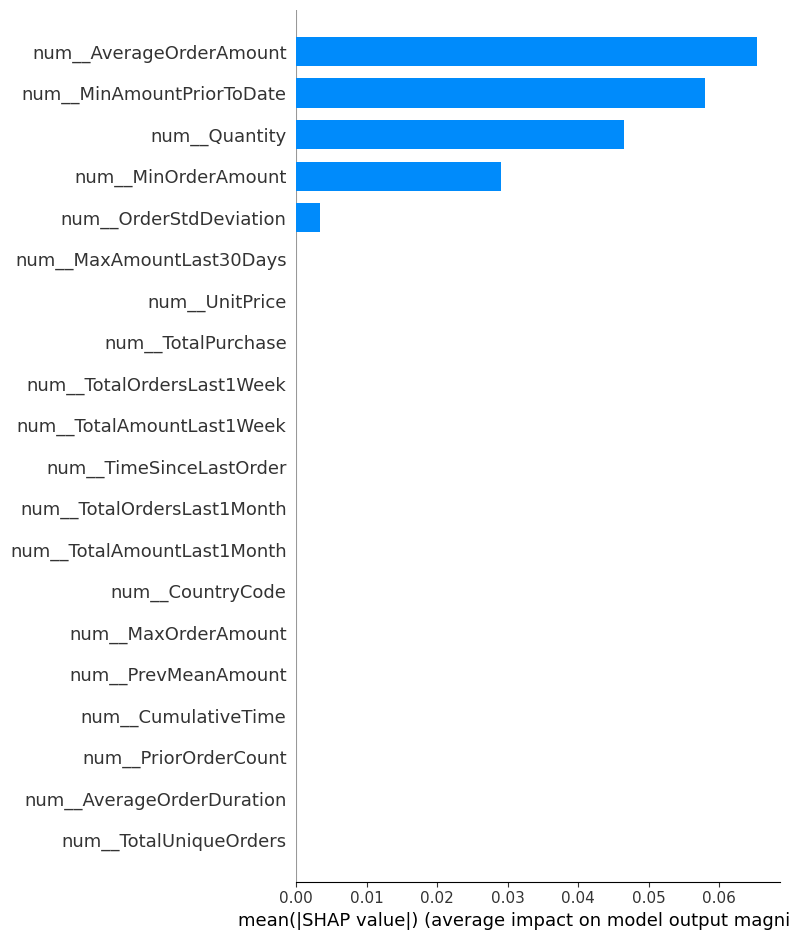

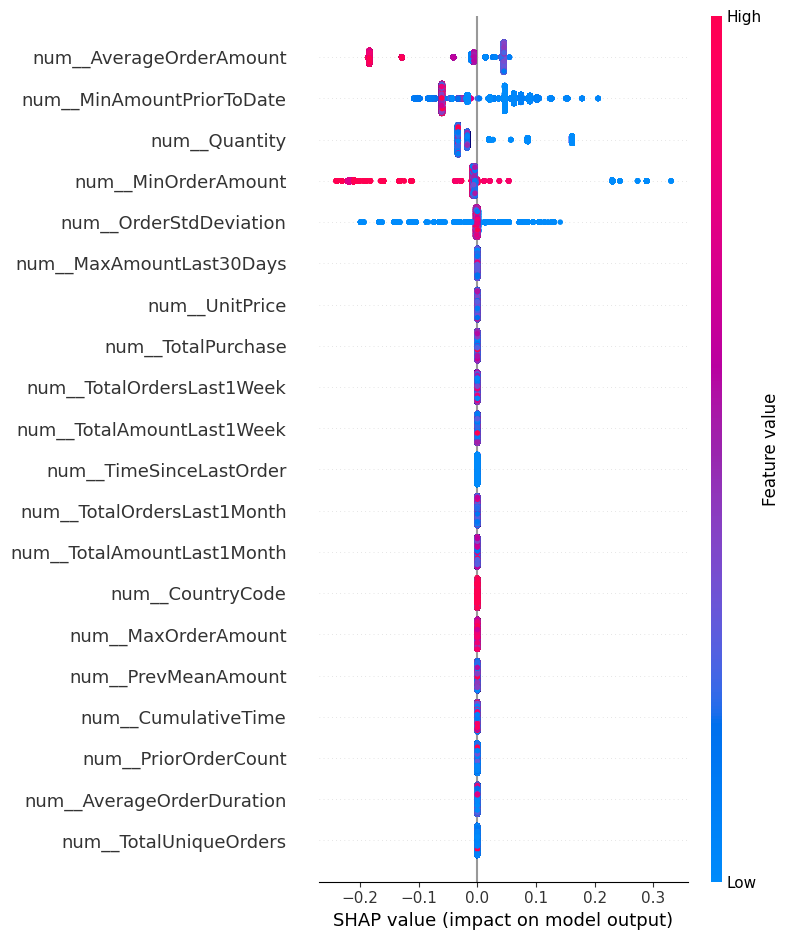

Performing SHAP analysis for Random Forest...


100%|===================| 206408/206636 [05:21<00:00]       

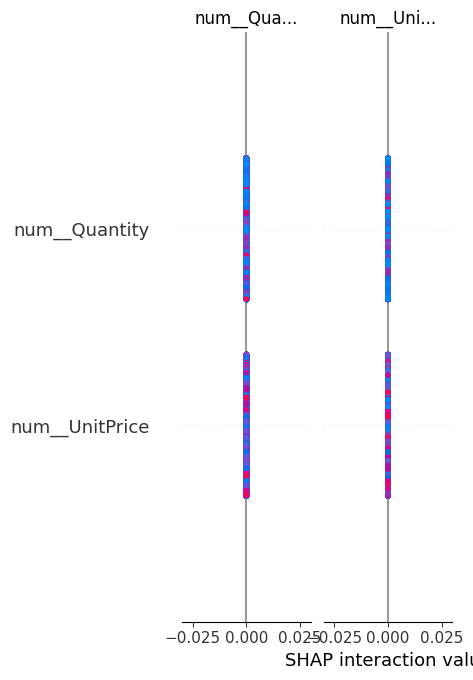

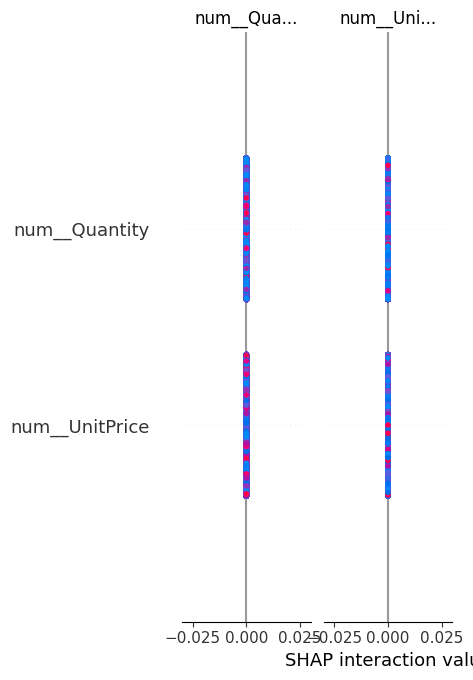

In [ ]:
!pip install shap
import shap
import matplotlib.pyplot as plt
import numpy as np

#Function for SHAP analysis
def shap_analysis(model, model_name, X_train, X_test, feature_names):
    # Create a TreeExplainer
    explainer = shap.Explainer(model.named_steps['classifier'], X_train)

    # Calculate SHAP values
    shap_values = explainer(X_test)

    # Plot summary plot
    shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_type="bar")
    shap.summary_plot(shap_values, X_test, feature_names=feature_names)


# Feature names after preprocessing
features = preprocessor.get_feature_names_out()

# Perform SHAP analysis for XGBoost
print("Performing SHAP analysis for XGBoost...")
shap_analysis(best_xgb_model, "XGBoost", X_train, X_test, features)

# Perform SHAP analysis for Random Forest
print("Performing SHAP analysis for Random Forest...")
shap_analysis(best_rf_model, "Random Forest", X_train, X_test, features)